## {working title} Hypergraph

This method optimizes a new cost function related to the original as:
$$ C = C_0 - \gamma \sum_i \Delta \theta_i^{(t)} \Delta \theta_i^{(t-1)}$$
The idea is that this new cost term, which we can tune the importance of via $\gamma$, directs optimizations to proceed in the direction of greater smoothness of the cost function, for better conditioning. There are many near-optimal solutions to the problem; why not search for the one that's easier for us to solve?

This is a cool method because it is computationally cheap when the function to be optimized can be written as a cascading computational graph. One simply constructs a new, larger graph (a 'hypergraph'), and performs backpropagation as normal upon this new graph.

The current term is based only on the intuition that it will be negative when consecutive updates are in opposite directions (a situation we do not want). Other related terms are possible, such as 
$$ C = C_0 - \gamma \sum_i \Delta \frac1{\theta_i^{(t)} \Delta \theta_i^{(t-1)}}$$
which has the desirable property that the $\theta_i$ will converge without setting a vanishing schedule for $\gamma$ (not the case for the first term), and that it encourages updates of the $\theta_i$ to be inversely related to the local curvature, in analogy to Newton's method (again, not the case for the first method). Alternatively, we can take inspiration from Runge-Kutta methods. The update deriving from the new cost
$$ C = C_0 - \gamma \sum_i \frac{\big|\frac{\partial C_0}{\partial\theta_i}^{(t)} - \frac{\partial C_0}{\partial\theta_i}^{(t-1)}\big|}{\Delta \theta_i^{(t)}} $$
explicitly places a bias against high curvature, for example.

**Q: why are RK methods not widespread in NN optimization?**

### Table of contents
0. Test Problems
    0. XOR
    0. Swiss roll (two-spiral)
    0. N-bit parity
    0. Iris dataset

    0. MNIST
0. Vanilla feedforward implementation
0. Convolutional implementation & testing
0. Recurrent implementation & testing
    0. Embedded reber grammar

In [30]:
import np as np
import matplotlib.pyplot as plt
import theano
from theano import tensor as T
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import six.moves.cPickle as pickle
import gzip
import os
import sys
import timeit
__docformat__ = 'restructedtext en'

%matplotlib inline

### Feedforward test problems

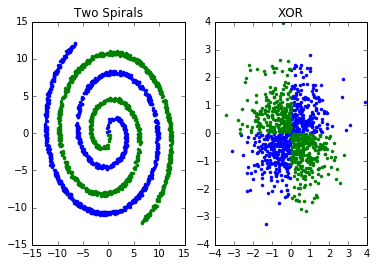

In [113]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
     Stolen from http://glowingpython.blogspot.com/2017/04/solving-two-spirals-problem-with-keras.html
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    
    X = np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y))))
    Y = np.hstack((np.zeros(n_points),np.ones(n_points)))
    
        # Convert into one-hot vectors
    num_labels = len(np.unique(Y))
    Y = np.eye(num_labels)[Y.astype(int)]
    
    return X, Y

def xor(n_points):
    X = np.random.randn(n_points, 2)
    Y = np.logical_xor(X[:,0]>0,X[:,1]>0)
    
    # Convert into one-hot vectors
    num_labels = len(np.unique(Y))
    Y = np.eye(num_labels)[Y.astype(int)]
    return X,Y


def get_iris_data():
    """ Read the iris data set and split them into training and test sets """
    iris   = datasets.load_iris()
    data   = iris.data
    target = iris.target

    # Prepend the column of 1s for bias
    N, M  = data.shape
    all_X = np.ones((N, M + 1))
    all_X[:, 1:] = data

    # Convert into one-hot vectors
    num_labels = len(np.unique(target))
    all_Y = np.eye(num_labels)[target]  # One liner trick!
    return all_X, all_Y


def load_mnist():
    ''' Loads the dataset. Copied from http://deeplearning.net/tutorial/logreg.html

    :type dataset: string
    :param dataset: the path to the dataset (here MNIST)
    '''

    #############
    # LOAD DATA #
    #############
    dataset = 'mnist.pkl.gz'
    # Download the MNIST dataset if it is not present
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join(
            os.path.split("__file__")[0],
            "..",
            "data",
            dataset
        )
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from six.moves import urllib
        origin = (
            'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        )
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, dataset)

    print('... loading data')

    # Load the dataset
    with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)
    # train_set, valid_set, test_set format: tuple(input, target)
    # input is a np.ndarray of 2 dimensions (a matrix)
    # where each row corresponds to an example. target is a
    # np.ndarray of 1 dimension (vector) that has the same length as
    # the number of rows in the input. It should give the target
    # to the example with the same index in the input.

    test_set_x, test_set_y = test_set
    valid_set_x, valid_set_y = valid_set
    train_set_x, train_set_y = train_set
    
        # Convert into one-hot vectors
    num_labels = len(np.unique(test_set_y))
    test_set_y = np.eye(num_labels)[test_set_y]
    valid_set_y = np.eye(num_labels)[valid_set_y]
    train_set_y = np.eye(num_labels)[train_set_y]

    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y),
            (test_set_x, test_set_y)]
    return rval
    
    
def shared_dataset(data_x, data_y, borrow=True):
    """ Function that loads the dataset into shared variables

    The reason we store our dataset in shared variables is to allow
    Theano to copy it into the GPU memory (when code is run on GPU).
    Since copying data into the GPU is slow, copying a minibatch everytime
    is needed (the default behaviour if the data is not in a shared
    variable) would lead to a large decrease in performance.
    """

    shared_x = theano.shared(np.asarray(data_x,
                                           dtype=theano.config.floatX),
                             borrow=borrow)
    shared_y = theano.shared(np.asarray(data_y,
                                           dtype=theano.config.floatX),
                             borrow=borrow)
    # When storing data on the GPU it has to be stored as floats
    # therefore we will store the labels as ``floatX`` as well
    # (``shared_y`` does exactly that). But during our computations
    # we need them as ints (we use labels as index, and if they are
    # floats it doesn't make sense) therefore instead of returning
    # ``shared_y`` we will have to cast it to int. This little hack
    # lets ous get around this issue
    return shared_x, shared_y   #T.cast(shared_y, 'int32')
    
plt.subplot(121)
plt.title('Two Spirals')
X, y = twospirals(1000)
plt.plot(X[y[:,0]>0,0], X[y[:,0]>0,1], '.', label='class 1')
plt.plot(X[y[:,1]>0,0], X[y[:,1]>0,1], '.', label='class 2')

plt.subplot(122)
plt.title('XOR')
X, y = xor(1000)
plt.plot(X[y[:,0]>0,0], X[y[:,0]>0,1], '.', label='class 1')
plt.plot(X[y[:,1]>0,0], X[y[:,1]>0,1], '.', label='class 2')


plt.show()

### Feedforward Theano network, by hand

In [114]:
# Implementation of a simple MLP network with one hidden layer. Tested on the iris data set.
# Requires: np, sklearn, theano

# Adapted from https://gist.github.com/vinhkhuc/20089f4abf9706d0cdc4 

# NOTE: In order to make the code simple, we rewrite x * W_1 + b_1 = x' * W_1' 
# where x' = [x | 1] and W_1' is the matrix W_1 appended with a new row with elements b_1's. 
# Similarly, for h * W_2 + b_2

def init_weights(shape):
    """ Weight initialization. Uses He initialization: the variance of a node
    is 2/n, where n is the number of feed-in nodes.
    
    Hardwired for 2D nodes.
    """
    assert len(shape)==2
    var = 2/shape[0]
    weights = np.asarray(np.random.randn(*shape) * np.sqrt(var), dtype=theano.config.floatX)
    return theano.shared(weights)

def backprop(cost, params, lr=0.01):
    """ Back-propagation """
    grads   = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        updates.append([p, p - g * lr])
    return updates

In [121]:
def fit_NN(train_X, test_X, train_y, test_y, shape = [256], n_epochs = 5, batch_size= 16, lr = 0.01, verbose = 0):
    """Constructs a feedforward NN classifer of specified shape.
        
    X = training data
    y = labels
    shape = List. Shape[i] = number of nodes in ith layer. NN has len(shape) layers."""


    if len(train_y.shape)<2:
        train_y = np.reshape(train_y,(train_y.shape[0],1))
    if len(test_y.shape)<2:
        test_y = np.reshape(test_y,(test_y.shape[0],1))
        
    
    # Symbols
    X_ = T.dmatrix()
    Y_ = T.dmatrix()
    index = T.lscalar()  # index to a [mini]batch

    # I/O sizes
    x_size = train_X.shape[1]             # Number of input nodes: 4 features and 1 bias
    y_size = train_y.shape[1]             # Number of outcomes (3 iris flowers)
    n_samples = train_X.shape[0]
    
    #make shared variables on GPU
    train_X_shared, train_y_shared = shared_dataset(train_X, train_y)
    test_X_shared, test_y_shared = shared_dataset(test_X, test_y)
    
    
    # Make & initialize layers
    w = list()
    w.append(init_weights((x_size, shape[0])))
    for l in range(len(shape)-1):
        w.append(init_weights((shape[l], shape[l+1])))
    w.append(init_weights((shape[-1], y_size)))

    # Forward propagation
    h = T.nnet.relu(T.dot(X_, w[0]))  # The \sigma function
    for l in range(len(shape)-1):
        h = T.nnet.relu(T.dot(h, w[l+1]))  # The \sigma function
    yhat = T.nnet.softmax(T.dot(h, w[-1]))  # The \varphi function

    # Backward propagation
    cost    = T.mean(T.nnet.categorical_crossentropy(yhat, Y_))
    params  = w
    updates = backprop(cost, params, lr)

    # Train and predict
    train   = theano.function(inputs = [index], 
                              givens={X_: train_X_shared[index * batch_size: (index + 1) * batch_size],
                                      Y_: train_y_shared[index * batch_size: (index + 1) * batch_size]}, 
                              outputs=cost, updates=updates, allow_input_downcast=True)
    pred_y  = T.argmax(yhat, axis=1)
    predict = theano.function(inputs=[X_], outputs=pred_y, allow_input_downcast=True)

    # Run SGD
    for iter in tqdm(range(n_epochs)):
        for minibatch_index in range(n_samples//batch_size):
            # currently throws out last n_sampless%batch_size samples
            train(minibatch_index)
                                      
        train_accuracy = np.mean(np.argmax(train_y, axis=1) == predict(train_X))
        test_accuracy  = np.mean(np.argmax(test_y, axis=1) == predict(test_X))
        if verbose > 1:
            print("Iteration = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
              % (iter + 1, 100 * train_accuracy, 100 * test_accuracy))
    if verbose > 0:
            print("Iteration = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
              % (iter + 1, 100 * train_accuracy, 100 * test_accuracy))
            
    return test_X, predict(test_X), test_accuracy

In [122]:
X, y = xor(1000)

# Get test and train splits
if len(y.shape)<2:
    y = np.reshape(y,(y.shape[0],1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33)

test_x, yhat, _ = fit_NN(train_X, test_X, train_y, test_y,
                                   shape = [8,5], n_epochs = 1000,batch_size = 16, lr = .1, verbose = 1)


100%|██████████| 1000/1000 [00:03<00:00, 303.94it/s]

Iteration = 1000, train accuracy = 98.66%, test accuracy = 98.18%


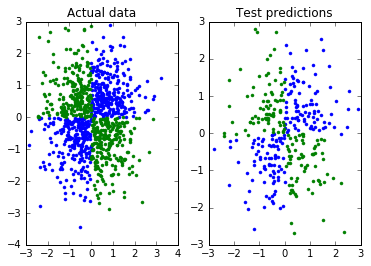

In [123]:
plt.subplot(121)
plt.title('Actual data')
plt.plot(X[y[:,0]>0,0], X[y[:,0]>0,1], '.', label='class 1')
plt.plot(X[y[:,1]>0,0], X[y[:,1]>0,1], '.', label='class 2')

plt.subplot(122)
plt.title('Test predictions')
X, y = xor(1000)
plt.plot(test_x[yhat==0,0], test_x[yhat==0,1], '.', label='class 1')
plt.plot(test_x[yhat==1,0], test_x[yhat==1,1], '.', label='class 2')

plt.show()

In [45]:
X, y = twospirals(1000)

# Get test and train splits
if len(y.shape)<2:
    y = np.reshape(y,(y.shape[0],1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33)
print(train_X.shape)
test_x, yhat, _ = split_and_fit_NN(X,y, shape = [86,9], n_epochs = 1000,batch_size = 22, lr = .02, verbose = 1)

(1340, 2)


100%|██████████| 1000/1000 [00:08<00:00, 115.62it/s]

Iteration = 1000, train accuracy = 57.46%, test accuracy = 53.18%


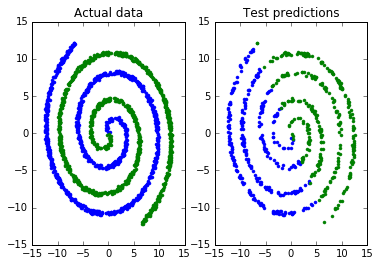

In [21]:
plt.subplot(121)
plt.title('Actual data')
plt.plot(X[y[:,0]>0,0], X[y[:,0]>0,1], '.', label='class 1')
plt.plot(X[y[:,1]>0,0], X[y[:,1]>0,1], '.', label='class 2')

plt.subplot(122)
plt.title('Test predictions')
X, y = xor(1000)
plt.plot(test_x[yhat==0,0], test_x[yhat==0,1], '.', label='class 1')
plt.plot(test_x[yhat==1,0], test_x[yhat==1,1], '.', label='class 2')

plt.show()

In [124]:
datasets = load_mnist()

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

test_x, yhat, _ = fit_NN(train_set_x, valid_set_x, train_set_y, valid_set_y, 
                                   shape = [800], n_epochs = 646,batch_size = 22, lr = .05, verbose = 1)

... loading data


  0%|          | 1/646 [00:07<1:21:02,  7.54s/it]


KeyboardInterrupt: 

## First test of hypergraph

In [20]:
def init_weights(shape):
    """ Weight initialization. Uses He initialization: the variance of a node
    is 2/n, where n is the number of feed-in nodes.
    
    Hardwired for 2D nodes.
    """
    assert len(shape)==2
    var = 2/shape[0]
    weights = np.asarray(np.random.randn(*shape) * np.sqrt(var), dtype=theano.config.floatX)
    return theano.shared(weights)



def split_and_fit_hyperNN(X, y, shape = [256], n_epochs = 5, batch_size= 16, lr = 0.01, verbose = 0, gamma = .01):
    """Constructs a feedforward NN classifer of specified shape,
            which updates based on the new rule described in the intro
        
    X = training data
    y = labels
    shape = List. Shape[i] = number of nodes in ith layer. NN has len(shape) layers."""
    
    # Get test and train splits
    if len(y.shape)<2:
        y = np.reshape(y,(y.shape[0],1))
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33)
    
    # Symbols
    X_ = T.fmatrix()
    Y_ = T.fmatrix()

    # I/O sizes
    x_size = train_X.shape[1]             # Number of input nodes
    y_size = train_y.shape[1]             # Number of outcomes
    n_samples = train_X.shape[0]
    
    # Make & initialize layers
    w = list()
    w.append(init_weights((x_size, shape[0])))
    for l in range(len(shape)-1):
        w.append(init_weights((shape[l], shape[l+1])))
    w.append(init_weights((shape[-1], y_size)))
    w1sum = init_weights((shape[l], shape[l+1])).sum()
    w1sum_printed = theano.printing.Print('this is a very important value')(w1sum)
    

    # Forward propagation
    h = T.nnet.relu(T.dot(X_, w[0]))  
    for l in range(len(shape)-1):
        h = T.nnet.relu(T.dot(h, w[l+1])) 
    yhat = T.nnet.softmax(T.dot(h, w[-1]))  # The \varphi function

    # Backward propagation
    cost    = T.mean(T.nnet.categorical_crossentropy(yhat, Y_))
    params  = w
    grads   = T.grad(cost=cost, wrt=params)     # Grads has shape shape as params, 1-1 mapping
    
    # Now take the grads*lr and store
    old_grads = grads    # initialize to be the same. old_grads will be updated
    
    # Create new cost
    #sum_grads = T.elemwise.Sum(T.elemwise.Elemwise(theano.scalar.Mul)(old_grads, grads)) * lr*lr
    sum_grads = 0
    for g, o in zip(grads, old_grads):
        sum_grads += (g*o).sum()
    full_cost = cost - gamma * sum_grads * lr*lr
    
    # Get new gradients
    full_grads   = T.grad(cost=full_cost, wrt=params)
    updates = []
    for p, fg, g, o in zip(params, full_grads, grads, old_grads):
        updates.append([p, p - fg * lr])
        #updates.append([o, g])


    # Train and predict
    train   = theano.function(inputs=[X_, Y_], outputs=full_cost, updates=updates, allow_input_downcast=True)
    pred_y  = T.argmax(yhat, axis=1)
    predict = theano.function(inputs=[X_], outputs=pred_y, allow_input_downcast=True)
    summ = theano.function(inputs=[], outputs=w1sum_printed, allow_input_downcast=True)

    # Run SGD
    for iter in tqdm(range(n_epochs)):
        for i in range(n_samples//batch_size):
            # currently throws out last n_sampless%batch_size samples
            s = i*batch_size
            e = (i+1)*batch_size
            train(train_X[s:e], train_y[s:e])
        train_accuracy = np.mean(np.argmax(train_y, axis=1) == predict(train_X))
        test_accuracy  = np.mean(np.argmax(test_y, axis=1) == predict(test_X))
        assert w1sum_printed
        if verbose > 1:
            print("Iteration = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
              % (iter + 1, 100 * train_accuracy, 100 * test_accuracy))
    if verbose > 0:
            print("Iteration = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
              % (iter + 1, 100 * train_accuracy, 100 * test_accuracy))
            
    return test_X, predict(test_X), test_accuracy

In [21]:
X, y = xor(1000)
test_x, yhat, _ = split_and_fit_hyperNN(X,y,  shape = [8,5], n_epochs = 1000,
                                        batch_size = 16, lr = .1, gamma=0.01, verbose = 1)

100%|██████████| 1000/1000 [00:08<00:00, 150.95it/s]

Iteration = 1000, train accuracy = 99.85%, test accuracy = 98.79%


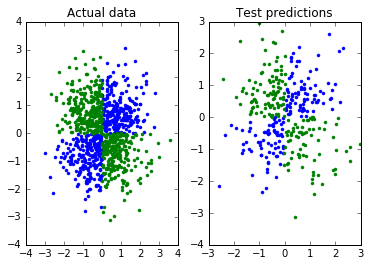

In [19]:
plt.subplot(121)
plt.title('Actual data')
plt.plot(X[y[:,0]>0,0], X[y[:,0]>0,1], '.', label='class 1')
plt.plot(X[y[:,1]>0,0], X[y[:,1]>0,1], '.', label='class 2')

plt.subplot(122)
plt.title('Test predictions')
X, y = xor(1000)
plt.plot(test_x[yhat==0,0], test_x[yhat==0,1], '.', label='class 1')
plt.plot(test_x[yhat==1,0], test_x[yhat==1,1], '.', label='class 2')

plt.show()

## Hyperparameter optimizations
For all, 100 interations using hyperopt

In [158]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK

space4rf = {
    'n_epochs': hp.uniform('n_epochs', 1,1000),
    'batch_size': hp.uniform('batch_size', 1,64),
    'lr': hp.loguniform('lr', np.log(1e-3),np.log(1)),
    'n1': hp.uniform('n1_', 1,100),
    'n2': hp.uniform('n2_', 1,20)
}

def fnc(params):

    _, _, acc = split_and_fit_NN(X,y, shape = [int(params['n1']),int(params['n2'])], 
                                 n_epochs = int(params['n_epochs']),
                                 batch_size = int(params['batch_size']), 
                                 lr = params['lr'], 
                                 verbose = 0)


    return -np.mean(acc)

In [ ]:
X, y = xor(1000)
xor_trials = Trials()
hyperoptBest = fmin(fnc, space4rf, algo=tpe.suggest, max_evals=100, trials=xor_trials)

In [159]:
X, y = twospirals(1000)
twos_trials = Trials()
hyperoptBest = fmin(fnc, space4rf, algo=tpe.suggest, max_evals=100, trials=twos_trials)

100%|██████████| 723/723 [00:22<00:00, 32.78it/s]


In [165]:
twos_trials.argmin

{'batch_size': 22.50000535825973,
 'lr': 0.160629712891533,
 'n1_': 86.08813764613983,
 'n2_': 9.516707726909068,
 'n_epochs': 646.3593636179205}